In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import numpy as np
import linecache #fast access to a specific file line
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import torch.nn.functional as F
import time
import torchinfo
from pathlib import Path

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.11.0
11.1
True


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
CONT_SIZE = 12

In [5]:
ALPHABET = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
            "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

ALPHABET = {ALPHABET[i]:i for i in range(len(ALPHABET))}

ALPHABET['-']= 20
ALPHABET['Z']= 21

print(ALPHABET)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, '-': 20, 'Z': 21}


In [6]:
class MyDataset(Dataset):
    def __init__(self, data_dir, cont_size=CONT_SIZE,div=1400000,verbose=False):
        
        self.col_size = 60 #number of column per file (Fasta standard)
        self.data_dir = data_dir #directory of the dataset
        self.cont_size = cont_size
        self.div = div
        self.len = 0  #number of families of sequences (1 per file)
        self.paths = {} #path of each families in the folder
        self.seq_lens = {} #length of each member of the family
        self.seq_nums = {} #number of member of the family
        self.aa_freqs = {} #frequencies of each symbol in the sequence family
        self.p_aa_freqs = {} #frequencies of each symbol in each sequence of a family
        
        
        dir_path = data_dir
        count = 0
        
        # Iterate directory
        for path in os.listdir(dir_path):
            # check if current path is a file
            temp_path = os.path.join(dir_path, path)
            if os.path.isfile(temp_path):
                n = 0 #number of sequences
                p = 0 # used to calculate the length of the sequences
                r = 0 # also used this way

                l = 0 # length of the seq l = p * self.col_size + r 

                cpt = 0 # to detect inconsistencies
                
                with open(temp_path, newline='') as f:
                    first_prot = True
                    newf = True
                    
                    aa_freq = torch.zeros(20)
                    p_aa_freq = torch.zeros(0)
                    
                    #parsing the file
                    line = f.readline()[:-1]
                    while line:
                        cpt += 1
                        if line[0] == '>': #header line
                            if not first_prot:
                                p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                            prot_aa_freq = torch.zeros(1,20)
                            n += 1
                            if newf and not first_prot:
                                newf = False
                            first_prot = False
                                
                        else:# sequence line
                            if newf and len(line) == self.col_size:
                                p += 1

                            if newf and len(line) != self.col_size:
                                r = len(line)
                            for aa in line:
                                aa_id = ALPHABET.get(aa,21)
                                if aa_id < 20:
                                    aa_freq[aa_id] += 1
                                    prot_aa_freq[0][aa_id] += 1

                            assert len(line) == self.col_size or len(line) == r
                        line = f.readline()[:-1]
                    
                    p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                    aa_freq = F.normalize(aa_freq,dim=0,p=1)
                    p_aa_freq = F.normalize(p_aa_freq,dim=1,p=1)

                l = p*self.col_size + r
                
                #sanity check
                #if the file line count is coherent with the number of sequences and their line count
                try: #if r != 0
                    assert (p+2) * n == cpt
                except: #if r == 0
                    assert (p+1) * n == cpt
                    assert r == 0
                    
                
                if n>1: #if this is false, we can't find pairs
                    self.paths[count] = path
                    self.seq_lens[count] = l
                    self.seq_nums[count] = n
                    self.aa_freqs[count] = aa_freq
                    self.p_aa_freqs[count] = p_aa_freq
                    count += 1
                    
                    if verbose and (count % 100 ==0) : print(f"seen = {count}")
            
        self.len = count
    
    def __len__(self):
        return self.len
     
    def sample(self, high, low=0, s=1):
        sample = np.random.choice(high-low, s, replace=False)
        return sample + low
    
    def __getitem__(self, idx, sample_size='auto'): 
        #for each sample:
        #sample i, j st i != j the two sequences to compare
        #sample k the sequence position of the prediction
        #compute the file positions of the 25 + 1 AA
        
        X = []
        y = []
        
        PIDs = []
        local_PIDs = []
        
        pfreqs = []
        local_pfreqs = []
        
        lengths = []
        
        pos = []
        
        
        precomputed_pos = []
        for i in range(-self.cont_size,self.cont_size+1):
            precomputed_pos.append(i)
        for i in range(-self.cont_size,0):
            precomputed_pos.append(i)
        for i in range(1,self.cont_size+1):
            precomputed_pos.append(i)
        
        precomputed_pos = torch.tensor(precomputed_pos).float()
        
        data_path = os.path.join(self.data_dir, self.paths[idx])
        try:
            n = self.seq_nums[idx]
            l = self.seq_lens[idx]
        except:
            print(idx)
            pass
        
        if type(sample_size) != int:
            coef = round((n**2 * l)/self.div) 
            sample_size = max(1,coef)
        
        p = l // self.col_size
        r = l % self.col_size # l = p * q + r
        sequence_line_count = p+2 if r else p+1


        for _ in range(sample_size):
            i,j = self.sample(n,s=2)

            start_i = 2 + (sequence_line_count)*i #start line of protein i
            start_j = 2 + (sequence_line_count)*j #start line of protein j
            
            seq_i = ''
            seq_j = ''
            
            PID_ij = 0
            
            l_ij = 0
            for offset in range(sequence_line_count-1):
                line_i = linecache.getline(data_path, (start_i + offset))[:-1]
                line_j = linecache.getline(data_path, (start_j + offset))[:-1]
                for aa_i, aa_j in zip(line_i,line_j):
                    if aa_i == aa_j:
                        if aa_i != '-':
                            PID_ij += 1
                            seq_i += aa_i
                            seq_j += aa_j        
                    else:
                        seq_i += aa_i
                        seq_j += aa_j
                    
                    if aa_i != '-' and aa_j != '-':
                        l_ij += 1
            
            try:
                PID_ij = PID_ij/l_ij
            except:
                PID_ij = 0
            
            align_l = len(seq_i)
            possible_k = []
            for k,(a_i,a_j) in enumerate(zip(seq_i,seq_j)):   
                if ALPHABET.get(a_i,21) < 20 and ALPHABET.get(a_j,21) < 20:
                    possible_k.append(k)
                    
            try:   
                k = np.random.choice(possible_k)
            except:
                continue
                
            lengths.append(align_l)
            pos_ij = (k + precomputed_pos)
            pos.append(pos_ij)
            
            window_i = ''
            window_j = ''
            
            for w in range(k-self.cont_size,k+self.cont_size+1):
                if w < 0 or w >= align_l: #case of the edges
                    window_i += 'Z'
                    window_j += 'Z'
                else:
                    window_i += seq_i[w]
                    window_j += seq_j[w]
        
            y_j = ALPHABET.get(window_j[self.cont_size], 21) # 'Z' is the default value for rare AA
            X_i = [ALPHABET.get(i, 21) for i in (window_i+window_j[:self.cont_size]+window_j[self.cont_size+1:])]       
            
            X.append(X_i)
            y.append(y_j)
            PIDs.append(PID_ij)
            local_PID_ij = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20) \
                         + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20)
            
            loc_comp = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20) \
                         + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20)
            try:
                tmp = local_PID_ij/loc_comp
            except:
                tmp = 0
                
            local_PIDs.append(tmp)
            pfreqs.append(self.aa_freqs[idx])
            p_i_freqs = self.p_aa_freqs[idx][i]
            p_j_freqs = self.p_aa_freqs[idx][j]
            
            local_pfreqs.append(torch.stack((p_i_freqs,p_j_freqs)))
            
            assert y_j < 20
            assert X_i[self.cont_size] < 20
            
        linecache.clearcache()   
        X = torch.tensor(X)
        try:
            X = F.one_hot(X,22)[:,:,0:-1]
        except RuntimeError:
            pass
        if len(pos) == 0:
            pos = torch.tensor(pos)
        else:
            pos = torch.stack(pos)
        pfreqs = torch.stack(pfreqs)
        local_pfreqs = torch.stack(local_pfreqs)
        X = X.float()
        y = torch.tensor(y)
        PIDs = torch.tensor(PIDs)
        local_PIDs = torch.tensor(local_PIDs)
        lengths = torch.tensor(lengths)
        out = X,y.long(),PIDs,local_PIDs,pfreqs,local_pfreqs,pos,lengths
        return out

    

In [7]:
"""
train_dataset = MyDataset(r"data/train_data",cont_size = 6)
test_dataset = MyDataset(r"data/test_data",cont_size = 6,div=700000)
val_dataset = MyDataset(r"data/val_data",cont_size = 6,div=700000)

fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(train_dataset,fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(test_dataset,fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(val_dataset,fp)
"""

'\ntrain_dataset = MyDataset(r"data/train_data",cont_size = 6)\ntest_dataset = MyDataset(r"data/test_data",cont_size = 6,div=700000)\nval_dataset = MyDataset(r"data/val_data",cont_size = 6,div=700000)\n\nfname = \'data/train_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(train_dataset,fp)\n    \nfname = \'data/test_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(test_dataset,fp)\n    \nfname = \'data/val_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(val_dataset,fp)\n'

In [12]:
fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    train_dataset = torch.load(fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    test_dataset = torch.load(fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    val_dataset = torch.load(fp)
    
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

train_dataset.cont_size = CONT_SIZE
test_dataset.cont_size = CONT_SIZE
val_dataset.cont_size = CONT_SIZE

13219
2838
2826


In [13]:
def my_collate(batch):
    data = torch.cat([item[0] for item in batch],dim=0)
    target = torch.cat([item[1] for item in batch],dim=0)
    PID = torch.cat([item[2] for item in batch],dim=0)
    lPID = torch.cat([item[3] for item in batch],dim=0)
    pfreqs = torch.cat([item[4] for item in batch],dim=0)
    lpfreqs = torch.cat([item[5] for item in batch],dim=0)
    pos = torch.cat([item[6] for item in batch],dim=0)
    length = torch.cat([item[7] for item in batch],dim=0)
    return data, target, PID, lPID,pfreqs,lpfreqs, pos, length

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

In [15]:
for data in train_dataloader:
    break
print(data[0].shape)

torch.Size([209, 49, 21])


In [16]:
class AttBlock(nn.Module):
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        Q = self.Q_w(x)
        K = self.K_w(x)
        V = self.V_w(x)
        out,_ = self.att(Q,K,V,need_weights=False)
        out = self.lin(out)
        
        return out

In [17]:
class FeedFoward(nn.Module):
    def __init__(self,in_features,out_features=None,wide_factor=4):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = wide_factor * in_features
        
        self.lin1 = nn.Linear(in_features,hidden_dim)
        self.act1 = nn.GELU()
        self.lin2 = nn.Linear(hidden_dim,out_features)
        self.act2 = nn.GELU()
        
    def forward(self,x):
        out = self.lin1(x)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        
        return out

In [18]:
def drop_path(x, drop_prob: float = 0.1, training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None, scale_by_keep=True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)


In [19]:
class Block(nn.Module):
    def __init__(self,in_features,num_heads=8,head_dims=24,wide_factor=4,drop=0.1):
        super().__init__()
        
        self.att_block = AttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.ff = FeedFoward(in_features,wide_factor=wide_factor)
        self.drop_path = DropPath(drop)
        
        self.norm1 = nn.LayerNorm(in_features)
        self.norm2 = nn.LayerNorm(in_features)
    def forward(self,x):
        out = x + self.drop_path(self.att_block(x))
        out = self.norm1(out)
        out = out + self.drop_path(self.ff(out))
        out = self.norm2(out)
        return out

In [20]:
class Classifier_Head(nn.Module):
    def __init__(self,in_features,clf_dims,out_size,seq_len):
        super().__init__()
        in_dim = seq_len*in_features
        self.in_dim = in_dim
        
        layers = []
        for out_dim in clf_dims:
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(p=0.2))
            in_dim = out_dim

        layers.append(nn.Linear(in_dim,out_size))
        
        self.clf = nn.Sequential(*layers)
        
    def forward(self,x):
        out = x.reshape((-1,self.in_dim))
        
        out = self.clf(out)
        
        return out

In [29]:
class AttNet(nn.Module):
    def __init__(self,in_features,num_heads,head_dims,wide_factors,drops,input_dim=21,out_size=20,seq_len=4*CONT_SIZE+6,clf_dims=[256,64],cont_size=CONT_SIZE):
        super().__init__()
        
        blocks = []
        for n_h, h_d,w,d in zip(num_heads,head_dims,wide_factors,drops):
            blocks.append(Block(in_features,num_heads=n_h,head_dims=h_d,wide_factor=w,drop=d))
        self.feature_extractor = nn.Sequential(*blocks)
        self.in_features = in_features
        self.input_dim = input_dim
        self.clf = Classifier_Head(in_features,clf_dims,out_size=out_size,seq_len=seq_len)
        
        self.cont_size=cont_size
        
        sp = Path("data/freq.pth")
        with sp.open("rb") as fp:
            self.F = nn.Parameter(torch.log(torch.load(fp)))
            
        pid_layers = [nn.Linear(1,in_features),nn.Sigmoid()]
        self.pid_l = nn.Sequential(*pid_layers)
    
    def to_input(self,x,PID,pfreqs,lpfreqs,pos,length):
        X_idx = torch.argmax(x[:,self.cont_size],dim=1)
        seq1 = x[:,:2*self.cont_size+1]
        y_freq = F.pad(F.softmax(self.F[X_idx],dim=1).unsqueeze(1), pad=(0, 1), mode='constant', value=0) 
        seq2 = torch.cat((x[:,2*self.cont_size+1:3*self.cont_size+1],y_freq,x[:,3*self.cont_size+1:]),dim=1)
        aa_pos = pos[:,:2*self.cont_size+1]/length.unsqueeze(1)
        aa_pos = aa_pos.unsqueeze(2)
        pos_dim = (self.in_features-self.input_dim-1)//2
        
        for i in range(pos_dim): #positionnal_encoding
            p = torch.cos(pos[:,:2*self.cont_size+1]/(4**(2*i/pos_dim))).unsqueeze(2)
            ip = torch.sin(pos[:,:2*self.cont_size+1]/(4**(2*i/pos_dim))).unsqueeze(2)
            aa_pos = torch.cat([aa_pos,p,ip],dim=2)
        
        seq1 = torch.cat([seq1,aa_pos],dim=2)
        seq2 = torch.cat([seq2,aa_pos],dim=2)
        X = torch.cat([seq1,seq2],dim=1)
        
        pad = (0,self.in_features-self.input_dim+1)
        pf = F.pad(pfreqs.unsqueeze(1),pad =pad, mode='constant', value=0)
        pid = self.pid_l(PID.unsqueeze(1)).unsqueeze(1)
        lpf = F.pad(lpfreqs,pad=pad, mode='constant', value=0)

        X_input = torch.cat([X,pf,lpf,pid],dim=1)
        
        return X_input
    
    def forward(self,x,PID,pfreqs,lpfreqs,pos,length):
        X_input = self.to_input(x,PID,pfreqs,lpfreqs,pos,length)
        features = self.feature_extractor(X_input)
        out = self.clf(features)
        return out

In [22]:
def get_params(input_size,N,head,head_dim,wide_factor,drop_prob):
    return input_size, [head for _ in range(N)], [head_dim for _ in range(N)], [wide_factor for _ in range(N)], [drop_prob for _ in range(N)], 

In [23]:
params = get_params(32,4,8,32,4,0.1)
model = AttNet(*params,clf_dims=[1024,256,64])
model = model.to(device)
torchinfo.summary(model,[(1,49,21),(1,),(1,20),(1,2,20),(1,49),(1,)])

Layer (type:depth-idx)                        Output Shape              Param #
AttNet                                        [1, 20]                   400
├─Sequential: 1-1                             [1, 32]                   --
│    └─Linear: 2-1                            [1, 32]                   64
│    └─Sigmoid: 2-2                           [1, 32]                   --
├─Sequential: 1-2                             [1, 54, 32]               --
│    └─Block: 2-3                             [1, 54, 32]               --
│    │    └─AttBlock: 3-1                     [1, 54, 32]               295,968
│    │    └─DropPath: 3-2                     [1, 54, 32]               --
│    │    └─LayerNorm: 3-3                    [1, 54, 32]               64
│    │    └─FeedFoward: 3-4                   [1, 54, 32]               8,352
│    │    └─DropPath: 3-5                     [1, 54, 32]               --
│    │    └─LayerNorm: 3-6                    [1, 54, 32]               64
│    └─Bloc

In [24]:
class State:
    def __init__(self,model,optim,scheduler):
        self.model = model
        self.optim = optim
        self.scheduler = scheduler
        self.epoch = 0

In [25]:
def eval_model(fname,train,test,val,N=10):
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
        
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())

        score_train = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_train = }\n")

        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs, pos,length in test:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_test = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_test = }\n")

        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs, pos, length in val:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                lPID = lPID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_val = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_val = }\n")
    
    return score_train, score_test, score_val

In [58]:
def eval_model_PID(fname,train,test,val,N=10):
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
    bin_n = 20
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_train = torch.zeros(bin_n)
        bar_train = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_train[i] += 1
            Losses_train[i] += n
        Losses_train = Losses_train/bar_train
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_train,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Train dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_train,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Train dataset")
        plt.show()
        
        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in test:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_test = torch.zeros(bin_n)
        bar_test = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_test[i] += 1
            Losses_test[i] += n
        Losses_test = Losses_test/bar_test
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_test,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Test dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_test,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Test dataset")
        plt.show()
        
        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in val:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_val = torch.zeros(bin_n)
        bar_val = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_val[i] += 1
            Losses_val[i] += n
        Losses_val = Losses_val/bar_val
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_val,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Val dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_val,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Val dataset")
        plt.show()
        
    return Losses_train, bar_val, Losses_test, bar_test, Losses_val,bar_val

In [59]:
def eval_model_acc_PID(fname,train,test,val,N=10):
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
    bin_n = 20
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
                
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_train = torch.zeros(bin_n)
        bar_train = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_train[i] += 1
            Losses_train[i] += n
        Losses_train = Losses_train/bar_train
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_train,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Train dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_train,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Train dataset")
        plt.show()
        
        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in test:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_test = torch.zeros(bin_n)
        bar_test = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_test[i] += 1
            Losses_test[i] += n
        Losses_test = Losses_test/bar_test
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_test,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Test dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_test,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Test dataset")
        plt.show()
        
        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in val:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_val = torch.zeros(bin_n)
        bar_val = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_val[i] += 1
            Losses_val[i] += n
        Losses_val = Losses_val/bar_val
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_val,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Val dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_val,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Val dataset")
        plt.show()
        
    return Losses_train, bar_val, Losses_test, bar_test, Losses_val,bar_val

In [27]:
def main(train_loader,val_loader,epochs=101,fname="models/state.pth",fnameb=None,state=None,last_epoch_sched=float('inf'),use_mut=True,cont_size=CONT_SIZE):
    
    #to get the best model
    best = float('inf')
    
    #getting the acceleration device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    #loading from previous checkpoint
    if fnameb is None:
        fnameb = fname[:-4] + '_best' +fname[-4:]
        
    savepath = Path(fname)
    if savepath.is_file():
        with savepath.open("rb") as fp:
            state = torch.load(fp)
    else:
        if state is None:
            model = AttNet(22,[8,8,8],[24,24,24],[4,4,4],[0.1,0.1,0.1])
            model = model.to(device)
            optim = torch.optim.AdamW(model.parameters(),lr = 0.0001)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
            state = State(model,optim,scheduler)
    
    
    Loss = nn.CrossEntropyLoss(reduction='sum')
    LossMut = nn.BCELoss(reduction='sum')
    EvalLoss = nn.MSELoss(reduction='mean')
    
    #for logs
    List_Loss = []
    Eval_Loss = []
    for epoch in range(state.epoch, epochs):
        batch_losses = []
        state.model.train()
        for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train_loader:
            X = X.to(device)
            y = y.to(device)
            PID = PID.to(device)
            pos = pos.to(device)
            pfreqs = pfreqs.to(device)
            lpfreqs = lpfreqs.to(device)
            length = length.to(device)
            
            state.optim.zero_grad()
            y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
            

            if use_mut:
                X_idx = torch.argmax(X[:,cont_size],dim=1)
                y_true = (X_idx == y).float().unsqueeze(1)  #0 if a mutation happens else 1 
                y_pred = F.softmax(y_hat,dim=1)
                y_pred = y_pred.gather(1,X_idx.view(-1,1)) #the Xth component of y_hat should be predicting ^
                l = (Loss(y_hat,y) + LossMut(y_pred,y_true))/311
            else:
                l = Loss(y_hat,y)/311
            l.backward()
            state.optim.step()
            
            
            
            batch_losses.append(l.detach().cpu())
        List_Loss.append(torch.mean(torch.stack(batch_losses)).detach().cpu())
        state.epoch = epoch + 1
        if epoch < last_epoch_sched:
            state.scheduler.step()
        
        savepath = Path(fname)
        with savepath.open("wb") as fp:
            torch.save(state,fp)
        
        with torch.no_grad():
            eval_losses = [] 
            state.model.eval()
            for X,y, PID, lPID,pfreqs,lpfreqs, pos,length in val_loader:

                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
            score = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
            Eval_Loss.append(score)
        
        if score < best :
            best = score
            savepath = Path(fnameb)
            with savepath.open("wb") as fp:
                torch.save(state,fp)
        
        print(f"epoch n°{epoch} : train_loss = {List_Loss[-1]}, val_loss = {Eval_Loss[-1]}") 


        
    return List_Loss,Eval_Loss,state

In [35]:
params = get_params(32,6,8,32,4,0.1)
model = AttNet(*params,clf_dims=[1024,256,64])
model = model.to(device)
optim = torch.optim.AdamW(model.parameters(),lr = 0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
state = State(model,optim,scheduler)

fname = "models/stateATT_6L_12cont.pth" 
start = time.time()
Train,Eval,_ = main(train_dataloader, val_dataloader,fname=fname,epochs=4080,state=state,use_mut=False)
stop = time.time()
print(stop-start)

epoch n°0 : train_loss = 2.833881378173828, val_loss = 0.8945793509483337
epoch n°1 : train_loss = 2.5380189418792725, val_loss = 0.847881019115448
epoch n°2 : train_loss = 2.4200780391693115, val_loss = 0.8292339444160461
epoch n°3 : train_loss = 2.380265712738037, val_loss = 0.8250608444213867
epoch n°4 : train_loss = 2.3605053424835205, val_loss = 0.8219791054725647
epoch n°5 : train_loss = 2.348021984100342, val_loss = 0.8174128532409668
epoch n°6 : train_loss = 2.3299314975738525, val_loss = 0.8195900321006775
epoch n°7 : train_loss = 2.3274009227752686, val_loss = 0.8119633793830872
epoch n°8 : train_loss = 2.328747510910034, val_loss = 0.818394660949707
epoch n°9 : train_loss = 2.309865713119507, val_loss = 0.8148890137672424
epoch n°10 : train_loss = 2.3132827281951904, val_loss = 0.8125910758972168
epoch n°11 : train_loss = 2.3008100986480713, val_loss = 0.8119771480560303
epoch n°12 : train_loss = 2.295570135116577, val_loss = 0.8128916025161743
epoch n°13 : train_loss = 2.30

epoch n°109 : train_loss = 2.1932599544525146, val_loss = 0.7993705868721008
epoch n°110 : train_loss = 2.1921684741973877, val_loss = 0.7956021428108215
epoch n°111 : train_loss = 2.1929028034210205, val_loss = 0.8008797764778137
epoch n°112 : train_loss = 2.2149369716644287, val_loss = 0.8023428320884705
epoch n°113 : train_loss = 2.2127039432525635, val_loss = 0.8059918880462646
epoch n°114 : train_loss = 2.2238664627075195, val_loss = 0.8053291440010071
epoch n°115 : train_loss = 2.2213573455810547, val_loss = 0.8034420013427734
epoch n°116 : train_loss = 2.215317487716675, val_loss = 0.8070060610771179
epoch n°117 : train_loss = 2.218419075012207, val_loss = 0.8089000582695007
epoch n°118 : train_loss = 2.2194132804870605, val_loss = 0.801056444644928
epoch n°119 : train_loss = 2.216170072555542, val_loss = 0.8042381405830383
epoch n°120 : train_loss = 2.221055269241333, val_loss = 0.8065146207809448
epoch n°121 : train_loss = 2.2168569564819336, val_loss = 0.8078108429908752
epoc

epoch n°217 : train_loss = 2.1518406867980957, val_loss = 0.7945185899734497
epoch n°218 : train_loss = 2.147085666656494, val_loss = 0.7901226878166199
epoch n°219 : train_loss = 2.1445322036743164, val_loss = 0.79734867811203
epoch n°220 : train_loss = 2.144967555999756, val_loss = 0.797551155090332
epoch n°221 : train_loss = 2.1550068855285645, val_loss = 0.7967642545700073
epoch n°222 : train_loss = 2.1426923274993896, val_loss = 0.796114444732666
epoch n°223 : train_loss = 2.148315191268921, val_loss = 0.7999545335769653
epoch n°224 : train_loss = 2.1546452045440674, val_loss = 0.7997134923934937
epoch n°225 : train_loss = 2.1507349014282227, val_loss = 0.7990236878395081
epoch n°226 : train_loss = 2.1499521732330322, val_loss = 0.7968701720237732
epoch n°227 : train_loss = 2.146946907043457, val_loss = 0.799281895160675
epoch n°228 : train_loss = 2.1537365913391113, val_loss = 0.8027647733688354
epoch n°229 : train_loss = 2.1437973976135254, val_loss = 0.7997820377349854
epoch n°

epoch n°325 : train_loss = 2.136913537979126, val_loss = 0.8004047870635986
epoch n°326 : train_loss = 2.133230209350586, val_loss = 0.8010155558586121
epoch n°327 : train_loss = 2.1412971019744873, val_loss = 0.8027360439300537
epoch n°328 : train_loss = 2.138340711593628, val_loss = 0.7997822165489197
epoch n°329 : train_loss = 2.1332736015319824, val_loss = 0.7982816696166992
epoch n°330 : train_loss = 2.1290619373321533, val_loss = 0.791782557964325
epoch n°331 : train_loss = 2.1325747966766357, val_loss = 0.7979611754417419
epoch n°332 : train_loss = 2.1431524753570557, val_loss = 0.7966352105140686
epoch n°333 : train_loss = 2.1341283321380615, val_loss = 0.8033909201622009
epoch n°334 : train_loss = 2.1366822719573975, val_loss = 0.7942241430282593
epoch n°335 : train_loss = 2.14068603515625, val_loss = 0.7987706661224365
epoch n°336 : train_loss = 2.1311070919036865, val_loss = 0.8014767169952393
epoch n°337 : train_loss = 2.1416845321655273, val_loss = 0.7994422316551208
epoch

epoch n°433 : train_loss = 2.0919625759124756, val_loss = 0.7955602407455444
epoch n°434 : train_loss = 2.097093105316162, val_loss = 0.7925117611885071
epoch n°435 : train_loss = 2.088024377822876, val_loss = 0.794137716293335
epoch n°436 : train_loss = 2.0947024822235107, val_loss = 0.7976617217063904
epoch n°437 : train_loss = 2.0931313037872314, val_loss = 0.7970126867294312
epoch n°438 : train_loss = 2.0947391986846924, val_loss = 0.7944467663764954
epoch n°439 : train_loss = 2.0957536697387695, val_loss = 0.7983844876289368
epoch n°440 : train_loss = 2.08978533744812, val_loss = 0.7990230321884155
epoch n°441 : train_loss = 2.0936832427978516, val_loss = 0.7991815209388733
epoch n°442 : train_loss = 2.086315155029297, val_loss = 0.7970519065856934
epoch n°443 : train_loss = 2.0938940048217773, val_loss = 0.7983235120773315
epoch n°444 : train_loss = 2.095170259475708, val_loss = 0.7949644923210144
epoch n°445 : train_loss = 2.082489013671875, val_loss = 0.7944487929344177
epoch n

epoch n°541 : train_loss = 2.1167430877685547, val_loss = 0.7958182692527771
epoch n°542 : train_loss = 2.113250494003296, val_loss = 0.8005331754684448
epoch n°543 : train_loss = 2.1198270320892334, val_loss = 0.8008208274841309
epoch n°544 : train_loss = 2.1260950565338135, val_loss = 0.799791157245636
epoch n°545 : train_loss = 2.1273372173309326, val_loss = 0.7991811633110046
epoch n°546 : train_loss = 2.1216559410095215, val_loss = 0.7986887693405151
epoch n°547 : train_loss = 2.1181442737579346, val_loss = 0.7985832095146179
epoch n°548 : train_loss = 2.1153202056884766, val_loss = 0.8027549982070923
epoch n°549 : train_loss = 2.1231236457824707, val_loss = 0.7999747395515442
epoch n°550 : train_loss = 2.1171977519989014, val_loss = 0.800482988357544
epoch n°551 : train_loss = 2.1217281818389893, val_loss = 0.8036878108978271
epoch n°552 : train_loss = 2.111166477203369, val_loss = 0.7983095049858093
epoch n°553 : train_loss = 2.116748332977295, val_loss = 0.7991349697113037
epoc

epoch n°649 : train_loss = 2.092879056930542, val_loss = 0.7999440431594849
epoch n°650 : train_loss = 2.0955212116241455, val_loss = 0.7972499132156372
epoch n°651 : train_loss = 2.095738172531128, val_loss = 0.7990171909332275
epoch n°652 : train_loss = 2.090071439743042, val_loss = 0.7989506721496582
epoch n°653 : train_loss = 2.0915207862854004, val_loss = 0.8019586205482483
epoch n°654 : train_loss = 2.0823566913604736, val_loss = 0.7962052822113037
epoch n°655 : train_loss = 2.096930742263794, val_loss = 0.7983742952346802
epoch n°656 : train_loss = 2.085597038269043, val_loss = 0.7976226806640625
epoch n°657 : train_loss = 2.0887398719787598, val_loss = 0.8000739812850952
epoch n°658 : train_loss = 2.093233823776245, val_loss = 0.7973282933235168
epoch n°659 : train_loss = 2.0933878421783447, val_loss = 0.79618901014328
epoch n°660 : train_loss = 2.0866894721984863, val_loss = 0.7967500686645508
epoch n°661 : train_loss = 2.094240427017212, val_loss = 0.7969339489936829
epoch n°

epoch n°757 : train_loss = 2.0672428607940674, val_loss = 0.7965834736824036
epoch n°758 : train_loss = 2.0663318634033203, val_loss = 0.7975685000419617
epoch n°759 : train_loss = 2.0662572383880615, val_loss = 0.796313464641571
epoch n°760 : train_loss = 2.062391519546509, val_loss = 0.7985281944274902
epoch n°761 : train_loss = 2.0654523372650146, val_loss = 0.7971079349517822
epoch n°762 : train_loss = 2.062439441680908, val_loss = 0.8001454472541809
epoch n°763 : train_loss = 2.077143907546997, val_loss = 0.7974114418029785
epoch n°764 : train_loss = 2.0672988891601562, val_loss = 0.7968677282333374
epoch n°765 : train_loss = 2.0639405250549316, val_loss = 0.7947155833244324
epoch n°766 : train_loss = 2.053741931915283, val_loss = 0.8013680577278137
epoch n°767 : train_loss = 2.05572247505188, val_loss = 0.7956795692443848
epoch n°768 : train_loss = 2.064147472381592, val_loss = 0.7949920296669006
epoch n°769 : train_loss = 2.064178705215454, val_loss = 0.7985135316848755
epoch n°

epoch n°865 : train_loss = 2.0486953258514404, val_loss = 0.7937902212142944
epoch n°866 : train_loss = 2.058058261871338, val_loss = 0.7946742177009583
epoch n°867 : train_loss = 2.0387518405914307, val_loss = 0.7949070930480957
epoch n°868 : train_loss = 2.0334784984588623, val_loss = 0.7967153191566467
epoch n°869 : train_loss = 2.0540969371795654, val_loss = 0.7959967255592346
epoch n°870 : train_loss = 2.0371739864349365, val_loss = 0.798068106174469
epoch n°871 : train_loss = 2.0483291149139404, val_loss = 0.7992578148841858
epoch n°872 : train_loss = 2.0444869995117188, val_loss = 0.7929940223693848
epoch n°873 : train_loss = 2.0537638664245605, val_loss = 0.7920240759849548
epoch n°874 : train_loss = 2.0407848358154297, val_loss = 0.797147810459137
epoch n°875 : train_loss = 2.0522053241729736, val_loss = 0.7997729778289795
epoch n°876 : train_loss = 2.045281410217285, val_loss = 0.7995148301124573
epoch n°877 : train_loss = 2.045469045639038, val_loss = 0.7949211597442627
epoc

epoch n°973 : train_loss = 2.035811185836792, val_loss = 0.7931947708129883
epoch n°974 : train_loss = 2.037832021713257, val_loss = 0.7967783808708191
epoch n°975 : train_loss = 2.034379482269287, val_loss = 0.7952852845191956
epoch n°976 : train_loss = 2.0355687141418457, val_loss = 0.7939900755882263
epoch n°977 : train_loss = 2.038780450820923, val_loss = 0.7938297390937805
epoch n°978 : train_loss = 2.03621506690979, val_loss = 0.7943670749664307
epoch n°979 : train_loss = 2.0375194549560547, val_loss = 0.7980536222457886
epoch n°980 : train_loss = 2.0418100357055664, val_loss = 0.7921482920646667
epoch n°981 : train_loss = 2.0354082584381104, val_loss = 0.7977628111839294
epoch n°982 : train_loss = 2.0312838554382324, val_loss = 0.7938926815986633
epoch n°983 : train_loss = 2.042402744293213, val_loss = 0.7929376363754272
epoch n°984 : train_loss = 2.0415198802948, val_loss = 0.7939010858535767
epoch n°985 : train_loss = 2.0286448001861572, val_loss = 0.793200671672821
epoch n°98

epoch n°1080 : train_loss = 2.0748519897460938, val_loss = 0.7988424301147461
epoch n°1081 : train_loss = 2.0718846321105957, val_loss = 0.7975396513938904
epoch n°1082 : train_loss = 2.081742763519287, val_loss = 0.7980037927627563
epoch n°1083 : train_loss = 2.0748636722564697, val_loss = 0.7990626096725464
epoch n°1084 : train_loss = 2.076807975769043, val_loss = 0.8019705414772034
epoch n°1085 : train_loss = 2.0731639862060547, val_loss = 0.8000437021255493
epoch n°1086 : train_loss = 2.0744497776031494, val_loss = 0.800225019454956
epoch n°1087 : train_loss = 2.069148302078247, val_loss = 0.7995655536651611
epoch n°1088 : train_loss = 2.0632147789001465, val_loss = 0.7976056337356567
epoch n°1089 : train_loss = 2.0691394805908203, val_loss = 0.7989581227302551
epoch n°1090 : train_loss = 2.0725207328796387, val_loss = 0.7959651947021484
epoch n°1091 : train_loss = 2.066694974899292, val_loss = 0.7981551885604858
epoch n°1092 : train_loss = 2.0708701610565186, val_loss = 0.79389154

epoch n°1186 : train_loss = 2.064640998840332, val_loss = 0.798508882522583
epoch n°1187 : train_loss = 2.0705039501190186, val_loss = 0.8031086921691895
epoch n°1188 : train_loss = 2.0626473426818848, val_loss = 0.8014387488365173
epoch n°1189 : train_loss = 2.0474393367767334, val_loss = 0.7982792854309082
epoch n°1190 : train_loss = 2.0617055892944336, val_loss = 0.7958813905715942
epoch n°1191 : train_loss = 2.0655901432037354, val_loss = 0.7974371910095215
epoch n°1192 : train_loss = 2.067457675933838, val_loss = 0.7989192605018616
epoch n°1193 : train_loss = 2.0691981315612793, val_loss = 0.7990608215332031
epoch n°1194 : train_loss = 2.0660274028778076, val_loss = 0.7991884350776672
epoch n°1195 : train_loss = 2.061037063598633, val_loss = 0.7939274907112122
epoch n°1196 : train_loss = 2.05887508392334, val_loss = 0.8012030124664307
epoch n°1197 : train_loss = 2.064629077911377, val_loss = 0.8043308854103088
epoch n°1198 : train_loss = 2.0631442070007324, val_loss = 0.7962565422

epoch n°1292 : train_loss = 2.0484488010406494, val_loss = 0.7962116599082947
epoch n°1293 : train_loss = 2.055084466934204, val_loss = 0.7949120998382568
epoch n°1294 : train_loss = 2.042677402496338, val_loss = 0.7967479825019836
epoch n°1295 : train_loss = 2.051032066345215, val_loss = 0.7925989031791687
epoch n°1296 : train_loss = 2.04667592048645, val_loss = 0.7990197539329529
epoch n°1297 : train_loss = 2.054400682449341, val_loss = 0.7954505681991577
epoch n°1298 : train_loss = 2.054863452911377, val_loss = 0.7975506782531738
epoch n°1299 : train_loss = 2.051978588104248, val_loss = 0.7999812960624695
epoch n°1300 : train_loss = 2.0493264198303223, val_loss = 0.7985854744911194
epoch n°1301 : train_loss = 2.049255847930908, val_loss = 0.795589804649353
epoch n°1302 : train_loss = 2.0637807846069336, val_loss = 0.7936916947364807
epoch n°1303 : train_loss = 2.053663492202759, val_loss = 0.7949782013893127
epoch n°1304 : train_loss = 2.042226552963257, val_loss = 0.794855356216430

epoch n°1398 : train_loss = 2.03348708152771, val_loss = 0.7992618083953857
epoch n°1399 : train_loss = 2.0372869968414307, val_loss = 0.7915961146354675
epoch n°1400 : train_loss = 2.048773765563965, val_loss = 0.7954642176628113
epoch n°1401 : train_loss = 2.03310227394104, val_loss = 0.7952328324317932
epoch n°1402 : train_loss = 2.038879156112671, val_loss = 0.7901952266693115
epoch n°1403 : train_loss = 2.0343170166015625, val_loss = 0.79757159948349
epoch n°1404 : train_loss = 2.0389363765716553, val_loss = 0.7978954911231995
epoch n°1405 : train_loss = 2.0347394943237305, val_loss = 0.7989702224731445
epoch n°1406 : train_loss = 2.039573907852173, val_loss = 0.7962795495986938
epoch n°1407 : train_loss = 2.0392632484436035, val_loss = 0.7979695200920105
epoch n°1408 : train_loss = 2.0362966060638428, val_loss = 0.7974788546562195
epoch n°1409 : train_loss = 2.0353593826293945, val_loss = 0.7944011092185974
epoch n°1410 : train_loss = 2.032735586166382, val_loss = 0.7963274121284

epoch n°1504 : train_loss = 2.028796434402466, val_loss = 0.7939417362213135
epoch n°1505 : train_loss = 2.0253653526306152, val_loss = 0.8014206290245056
epoch n°1506 : train_loss = 2.0285775661468506, val_loss = 0.8024968504905701
epoch n°1507 : train_loss = 2.028984546661377, val_loss = 0.7937800884246826
epoch n°1508 : train_loss = 2.0265862941741943, val_loss = 0.795263409614563
epoch n°1509 : train_loss = 2.0212273597717285, val_loss = 0.7954446077346802
epoch n°1510 : train_loss = 2.023984909057617, val_loss = 0.7946920990943909
epoch n°1511 : train_loss = 2.0241146087646484, val_loss = 0.7944477796554565
epoch n°1512 : train_loss = 2.0283777713775635, val_loss = 0.7950464487075806
epoch n°1513 : train_loss = 2.0182745456695557, val_loss = 0.7953868508338928
epoch n°1514 : train_loss = 2.0136077404022217, val_loss = 0.7971518635749817
epoch n°1515 : train_loss = 2.0273706912994385, val_loss = 0.7962302565574646
epoch n°1516 : train_loss = 2.029374599456787, val_loss = 0.79654014

epoch n°1610 : train_loss = 2.020733594894409, val_loss = 0.7950260639190674
epoch n°1611 : train_loss = 2.0194966793060303, val_loss = 0.7922741174697876
epoch n°1612 : train_loss = 2.0167078971862793, val_loss = 0.7919750809669495
epoch n°1613 : train_loss = 2.016643762588501, val_loss = 0.7956346869468689
epoch n°1614 : train_loss = 2.0230181217193604, val_loss = 0.7941478490829468
epoch n°1615 : train_loss = 2.024888038635254, val_loss = 0.7990204691886902
epoch n°1616 : train_loss = 2.0094335079193115, val_loss = 0.7955983877182007
epoch n°1617 : train_loss = 2.011504650115967, val_loss = 0.7905575633049011
epoch n°1618 : train_loss = 2.01883602142334, val_loss = 0.7945789694786072
epoch n°1619 : train_loss = 2.0093979835510254, val_loss = 0.794626772403717
epoch n°1620 : train_loss = 2.0202183723449707, val_loss = 0.7916523218154907
epoch n°1621 : train_loss = 2.0138347148895264, val_loss = 0.793426513671875
epoch n°1622 : train_loss = 2.011394500732422, val_loss = 0.792023003101

epoch n°1716 : train_loss = 2.000100612640381, val_loss = 0.7940003871917725
epoch n°1717 : train_loss = 2.004115343093872, val_loss = 0.7891745567321777
epoch n°1718 : train_loss = 2.004344940185547, val_loss = 0.7955000996589661
epoch n°1719 : train_loss = 2.0084967613220215, val_loss = 0.7949382066726685
epoch n°1720 : train_loss = 2.0096487998962402, val_loss = 0.7920786142349243
epoch n°1721 : train_loss = 2.012556314468384, val_loss = 0.791542112827301
epoch n°1722 : train_loss = 2.0024468898773193, val_loss = 0.7928888201713562
epoch n°1723 : train_loss = 2.0016562938690186, val_loss = 0.794322669506073
epoch n°1724 : train_loss = 2.0059127807617188, val_loss = 0.7934252619743347
epoch n°1725 : train_loss = 2.0062973499298096, val_loss = 0.7983884215354919
epoch n°1726 : train_loss = 1.9992287158966064, val_loss = 0.7940785884857178
epoch n°1727 : train_loss = 1.9989690780639648, val_loss = 0.7959399819374084
epoch n°1728 : train_loss = 2.0069942474365234, val_loss = 0.795920729

epoch n°1822 : train_loss = 1.9915707111358643, val_loss = 0.7924279570579529
epoch n°1823 : train_loss = 1.9985207319259644, val_loss = 0.7953193187713623
epoch n°1824 : train_loss = 1.997092604637146, val_loss = 0.7977349162101746
epoch n°1825 : train_loss = 1.994459629058838, val_loss = 0.7906603813171387
epoch n°1826 : train_loss = 1.9946258068084717, val_loss = 0.7955904603004456
epoch n°1827 : train_loss = 2.0010876655578613, val_loss = 0.7926191687583923
epoch n°1828 : train_loss = 1.995934247970581, val_loss = 0.7893484830856323
epoch n°1829 : train_loss = 1.9950928688049316, val_loss = 0.7937800288200378
epoch n°1830 : train_loss = 1.9972119331359863, val_loss = 0.7962270379066467
epoch n°1831 : train_loss = 1.9980543851852417, val_loss = 0.7941787838935852
epoch n°1832 : train_loss = 1.9942662715911865, val_loss = 0.7923968434333801
epoch n°1833 : train_loss = 1.9922360181808472, val_loss = 0.7943512201309204
epoch n°1834 : train_loss = 1.994403600692749, val_loss = 0.7939835

epoch n°1928 : train_loss = 1.9985132217407227, val_loss = 0.7970977425575256
epoch n°1929 : train_loss = 1.986410140991211, val_loss = 0.7945358157157898
epoch n°1930 : train_loss = 2.0023319721221924, val_loss = 0.7961223125457764
epoch n°1931 : train_loss = 1.9944713115692139, val_loss = 0.7944269776344299
epoch n°1932 : train_loss = 1.9909477233886719, val_loss = 0.7928091883659363
epoch n°1933 : train_loss = 1.9877686500549316, val_loss = 0.7925757765769958
epoch n°1934 : train_loss = 2.0034842491149902, val_loss = 0.7942293882369995
epoch n°1935 : train_loss = 1.9955980777740479, val_loss = 0.7911986708641052
epoch n°1936 : train_loss = 1.9937101602554321, val_loss = 0.7955973744392395
epoch n°1937 : train_loss = 1.9999732971191406, val_loss = 0.795078456401825
epoch n°1938 : train_loss = 1.9973207712173462, val_loss = 0.7914717793464661
epoch n°1939 : train_loss = 1.98971688747406, val_loss = 0.798121452331543
epoch n°1940 : train_loss = 1.993988037109375, val_loss = 0.792852520

epoch n°2034 : train_loss = 2.018387794494629, val_loss = 0.7996106743812561
epoch n°2035 : train_loss = 2.0251305103302, val_loss = 0.7974691987037659
epoch n°2036 : train_loss = 2.0216450691223145, val_loss = 0.7968572974205017
epoch n°2037 : train_loss = 2.014371633529663, val_loss = 0.8002721071243286
epoch n°2038 : train_loss = 2.028841495513916, val_loss = 0.7982180714607239
epoch n°2039 : train_loss = 2.027780055999756, val_loss = 0.7969425320625305
epoch n°2040 : train_loss = 2.026578187942505, val_loss = 0.7967298030853271
epoch n°2041 : train_loss = 2.030616283416748, val_loss = 0.8030699491500854
epoch n°2042 : train_loss = 2.0328752994537354, val_loss = 0.7999603748321533
epoch n°2043 : train_loss = 2.019284248352051, val_loss = 0.8010504245758057
epoch n°2044 : train_loss = 2.0367515087127686, val_loss = 0.7956922650337219
epoch n°2045 : train_loss = 2.0279555320739746, val_loss = 0.798614501953125
epoch n°2046 : train_loss = 2.0273072719573975, val_loss = 0.79885214567184

epoch n°2140 : train_loss = 2.038343906402588, val_loss = 0.8007562756538391
epoch n°2141 : train_loss = 2.0397558212280273, val_loss = 0.7949919700622559
epoch n°2142 : train_loss = 2.0426595211029053, val_loss = 0.8001787662506104
epoch n°2143 : train_loss = 2.0385820865631104, val_loss = 0.7968814969062805
epoch n°2144 : train_loss = 2.0345571041107178, val_loss = 0.8013330101966858
epoch n°2145 : train_loss = 2.0420212745666504, val_loss = 0.7999535799026489
epoch n°2146 : train_loss = 2.0430214405059814, val_loss = 0.7954010367393494
epoch n°2147 : train_loss = 2.0445353984832764, val_loss = 0.7975439429283142
epoch n°2148 : train_loss = 2.040631055831909, val_loss = 0.7953170537948608
epoch n°2149 : train_loss = 2.037616729736328, val_loss = 0.8002461791038513
epoch n°2150 : train_loss = 2.045206308364868, val_loss = 0.795200526714325
epoch n°2151 : train_loss = 2.036550998687744, val_loss = 0.7894007563591003
epoch n°2152 : train_loss = 2.0388588905334473, val_loss = 0.795863926

epoch n°2246 : train_loss = 2.0368058681488037, val_loss = 0.7956848740577698
epoch n°2247 : train_loss = 2.0339579582214355, val_loss = 0.7973909974098206
epoch n°2248 : train_loss = 2.029006242752075, val_loss = 0.7976851463317871
epoch n°2249 : train_loss = 2.0358822345733643, val_loss = 0.8010396361351013
epoch n°2250 : train_loss = 2.0432467460632324, val_loss = 0.7978963255882263
epoch n°2251 : train_loss = 2.0340936183929443, val_loss = 0.7991258502006531
epoch n°2252 : train_loss = 2.0400335788726807, val_loss = 0.8007068634033203
epoch n°2253 : train_loss = 2.037890911102295, val_loss = 0.792211651802063
epoch n°2254 : train_loss = 2.0337636470794678, val_loss = 0.7978325486183167
epoch n°2255 : train_loss = 2.036867141723633, val_loss = 0.7951281070709229
epoch n°2256 : train_loss = 2.0410568714141846, val_loss = 0.8012768030166626
epoch n°2257 : train_loss = 2.0332047939300537, val_loss = 0.8009181022644043
epoch n°2258 : train_loss = 2.042386293411255, val_loss = 0.79369240

epoch n°2352 : train_loss = 2.0483908653259277, val_loss = 0.8014090061187744
epoch n°2353 : train_loss = 2.038264274597168, val_loss = 0.8019989132881165
epoch n°2354 : train_loss = 2.0329201221466064, val_loss = 0.7974583506584167
epoch n°2355 : train_loss = 2.035693407058716, val_loss = 0.7996357679367065
epoch n°2356 : train_loss = 2.0332062244415283, val_loss = 0.7963980436325073
epoch n°2357 : train_loss = 2.0214908123016357, val_loss = 0.7955079674720764
epoch n°2358 : train_loss = 2.0394368171691895, val_loss = 0.7962828278541565
epoch n°2359 : train_loss = 2.0292904376983643, val_loss = 0.7957931756973267
epoch n°2360 : train_loss = 2.045152425765991, val_loss = 0.7927391529083252
epoch n°2361 : train_loss = 2.033951997756958, val_loss = 0.7975122928619385
epoch n°2362 : train_loss = 2.036473035812378, val_loss = 0.7984011769294739
epoch n°2363 : train_loss = 2.0368423461914062, val_loss = 0.7979052662849426
epoch n°2364 : train_loss = 2.0403976440429688, val_loss = 0.79746270

epoch n°2458 : train_loss = 2.0245201587677, val_loss = 0.796033501625061
epoch n°2459 : train_loss = 2.0312352180480957, val_loss = 0.7992179989814758
epoch n°2460 : train_loss = 2.0379269123077393, val_loss = 0.789661705493927
epoch n°2461 : train_loss = 2.025968313217163, val_loss = 0.7952430844306946
epoch n°2462 : train_loss = 2.0308988094329834, val_loss = 0.7969427704811096
epoch n°2463 : train_loss = 2.0233230590820312, val_loss = 0.7922908067703247
epoch n°2464 : train_loss = 2.0269031524658203, val_loss = 0.7939020991325378
epoch n°2465 : train_loss = 2.0279886722564697, val_loss = 0.7973837852478027
epoch n°2466 : train_loss = 2.0299055576324463, val_loss = 0.7960924506187439
epoch n°2467 : train_loss = 2.036625623703003, val_loss = 0.7997392416000366
epoch n°2468 : train_loss = 2.026195526123047, val_loss = 0.7977868318557739
epoch n°2469 : train_loss = 2.0199458599090576, val_loss = 0.8007630109786987
epoch n°2470 : train_loss = 2.01315975189209, val_loss = 0.7936212420463

epoch n°2564 : train_loss = 2.0203704833984375, val_loss = 0.7928557991981506
epoch n°2565 : train_loss = 2.006904363632202, val_loss = 0.7957596182823181
epoch n°2566 : train_loss = 2.019211769104004, val_loss = 0.7929474115371704
epoch n°2567 : train_loss = 2.0238711833953857, val_loss = 0.7964243292808533
epoch n°2568 : train_loss = 2.023331880569458, val_loss = 0.7938019037246704
epoch n°2569 : train_loss = 2.027726411819458, val_loss = 0.7939556837081909
epoch n°2570 : train_loss = 2.022156000137329, val_loss = 0.7995558381080627
epoch n°2571 : train_loss = 2.01847243309021, val_loss = 0.7939452528953552
epoch n°2572 : train_loss = 2.018853187561035, val_loss = 0.7932080030441284
epoch n°2573 : train_loss = 2.026092529296875, val_loss = 0.7974068522453308
epoch n°2574 : train_loss = 2.0222415924072266, val_loss = 0.7983753681182861
epoch n°2575 : train_loss = 2.0184037685394287, val_loss = 0.8003817796707153
epoch n°2576 : train_loss = 2.024414300918579, val_loss = 0.7958230376243

epoch n°2670 : train_loss = 2.0171408653259277, val_loss = 0.7938448190689087
epoch n°2671 : train_loss = 2.0128462314605713, val_loss = 0.7941492199897766
epoch n°2672 : train_loss = 2.01108455657959, val_loss = 0.7990132570266724
epoch n°2673 : train_loss = 2.014518976211548, val_loss = 0.7981889247894287
epoch n°2674 : train_loss = 2.0178885459899902, val_loss = 0.7946653962135315
epoch n°2675 : train_loss = 2.018657922744751, val_loss = 0.7945234179496765
epoch n°2676 : train_loss = 2.0150742530822754, val_loss = 0.7991363406181335
epoch n°2677 : train_loss = 2.007456064224243, val_loss = 0.7939445376396179
epoch n°2678 : train_loss = 2.008899450302124, val_loss = 0.7958813905715942
epoch n°2679 : train_loss = 2.010892629623413, val_loss = 0.7953510880470276
epoch n°2680 : train_loss = 2.010930299758911, val_loss = 0.7963590025901794
epoch n°2681 : train_loss = 2.0139575004577637, val_loss = 0.7978529930114746
epoch n°2682 : train_loss = 2.01906418800354, val_loss = 0.7976355552673

epoch n°2776 : train_loss = 2.001847505569458, val_loss = 0.7928353548049927
epoch n°2777 : train_loss = 2.010960340499878, val_loss = 0.7932294607162476
epoch n°2778 : train_loss = 2.0043818950653076, val_loss = 0.7978988885879517
epoch n°2779 : train_loss = 2.0215654373168945, val_loss = 0.7954546809196472
epoch n°2780 : train_loss = 2.016751527786255, val_loss = 0.7917622923851013
epoch n°2781 : train_loss = 2.0050389766693115, val_loss = 0.7983554005622864
epoch n°2782 : train_loss = 2.0068228244781494, val_loss = 0.7969391345977783
epoch n°2783 : train_loss = 2.0006537437438965, val_loss = 0.7960596084594727
epoch n°2784 : train_loss = 2.011685848236084, val_loss = 0.7955777645111084
epoch n°2785 : train_loss = 2.0057008266448975, val_loss = 0.7918356657028198
epoch n°2786 : train_loss = 2.0048160552978516, val_loss = 0.7975392937660217
epoch n°2787 : train_loss = 2.0055007934570312, val_loss = 0.7951236963272095
epoch n°2788 : train_loss = 2.002533197402954, val_loss = 0.79615861

epoch n°2882 : train_loss = 1.9977861642837524, val_loss = 0.7938411831855774
epoch n°2883 : train_loss = 1.9905657768249512, val_loss = 0.7918250560760498
epoch n°2884 : train_loss = 2.0057685375213623, val_loss = 0.7980883121490479
epoch n°2885 : train_loss = 2.0060875415802, val_loss = 0.7949978113174438
epoch n°2886 : train_loss = 2.0054450035095215, val_loss = 0.7916783690452576
epoch n°2887 : train_loss = 2.0002329349517822, val_loss = 0.7946237921714783
epoch n°2888 : train_loss = 1.9973987340927124, val_loss = 0.7954577803611755
epoch n°2889 : train_loss = 2.0012247562408447, val_loss = 0.7946457862854004
epoch n°2890 : train_loss = 1.997316837310791, val_loss = 0.7976753115653992
epoch n°2891 : train_loss = 2.008965015411377, val_loss = 0.7916777729988098
epoch n°2892 : train_loss = 2.0036747455596924, val_loss = 0.7948097586631775
epoch n°2893 : train_loss = 2.0043864250183105, val_loss = 0.7914943099021912
epoch n°2894 : train_loss = 2.001284599304199, val_loss = 0.791692197

epoch n°2988 : train_loss = 2.0034468173980713, val_loss = 0.7949668765068054
epoch n°2989 : train_loss = 1.9960626363754272, val_loss = 0.7914276123046875
epoch n°2990 : train_loss = 1.9986391067504883, val_loss = 0.7954105138778687
epoch n°2991 : train_loss = 2.0002949237823486, val_loss = 0.7927151918411255
epoch n°2992 : train_loss = 1.996838092803955, val_loss = 0.7971926927566528
epoch n°2993 : train_loss = 1.9930564165115356, val_loss = 0.7946171760559082
epoch n°2994 : train_loss = 1.9973284006118774, val_loss = 0.7964571714401245
epoch n°2995 : train_loss = 1.9895825386047363, val_loss = 0.789698600769043
epoch n°2996 : train_loss = 1.9970675706863403, val_loss = 0.7953345775604248
epoch n°2997 : train_loss = 1.9972470998764038, val_loss = 0.795199990272522
epoch n°2998 : train_loss = 1.9890848398208618, val_loss = 0.7947072386741638
epoch n°2999 : train_loss = 1.9998314380645752, val_loss = 0.7957807779312134
epoch n°3000 : train_loss = 2.0002999305725098, val_loss = 0.794286

epoch n°3094 : train_loss = 1.9905730485916138, val_loss = 0.7955367565155029
epoch n°3095 : train_loss = 1.9875340461730957, val_loss = 0.7926775813102722
epoch n°3096 : train_loss = 1.9950101375579834, val_loss = 0.7944870591163635
epoch n°3097 : train_loss = 1.998485803604126, val_loss = 0.7964071035385132
epoch n°3098 : train_loss = 1.98931884765625, val_loss = 0.7907314896583557
epoch n°3099 : train_loss = 1.9907969236373901, val_loss = 0.7922073006629944
epoch n°3100 : train_loss = 1.9876770973205566, val_loss = 0.7920311093330383
epoch n°3101 : train_loss = 1.9971786737442017, val_loss = 0.7952823638916016
epoch n°3102 : train_loss = 1.9946197271347046, val_loss = 0.7958129048347473
epoch n°3103 : train_loss = 1.986869215965271, val_loss = 0.7937372922897339
epoch n°3104 : train_loss = 1.9880485534667969, val_loss = 0.7980996966362
epoch n°3105 : train_loss = 1.9928319454193115, val_loss = 0.7935894727706909
epoch n°3106 : train_loss = 1.984537959098816, val_loss = 0.79692465066

epoch n°3200 : train_loss = 1.9768999814987183, val_loss = 0.7926162481307983
epoch n°3201 : train_loss = 1.9919002056121826, val_loss = 0.7922276258468628
epoch n°3202 : train_loss = 1.9866652488708496, val_loss = 0.7961506843566895
epoch n°3203 : train_loss = 1.9736733436584473, val_loss = 0.789436399936676
epoch n°3204 : train_loss = 1.9776585102081299, val_loss = 0.7969439625740051
epoch n°3205 : train_loss = 1.9822769165039062, val_loss = 0.7892331480979919
epoch n°3206 : train_loss = 1.9822449684143066, val_loss = 0.7926850914955139
epoch n°3207 : train_loss = 1.9846417903900146, val_loss = 0.7953557372093201
epoch n°3208 : train_loss = 1.9785951375961304, val_loss = 0.7954214215278625
epoch n°3209 : train_loss = 1.9694232940673828, val_loss = 0.7938094139099121
epoch n°3210 : train_loss = 1.9875184297561646, val_loss = 0.7924420833587646
epoch n°3211 : train_loss = 1.9823215007781982, val_loss = 0.7947884798049927
epoch n°3212 : train_loss = 1.9882220029830933, val_loss = 0.7946

epoch n°3306 : train_loss = 1.9806236028671265, val_loss = 0.7940238118171692
epoch n°3307 : train_loss = 1.9792052507400513, val_loss = 0.7923587560653687
epoch n°3308 : train_loss = 1.9821803569793701, val_loss = 0.7926502823829651
epoch n°3309 : train_loss = 1.9844205379486084, val_loss = 0.7884906530380249
epoch n°3310 : train_loss = 1.9690849781036377, val_loss = 0.7926296591758728
epoch n°3311 : train_loss = 1.9810690879821777, val_loss = 0.7920770049095154
epoch n°3312 : train_loss = 1.9772697687149048, val_loss = 0.78791344165802
epoch n°3313 : train_loss = 1.9833130836486816, val_loss = 0.7913944721221924
epoch n°3314 : train_loss = 1.9779764413833618, val_loss = 0.7893940806388855
epoch n°3315 : train_loss = 1.9770493507385254, val_loss = 0.794300377368927
epoch n°3316 : train_loss = 1.9789217710494995, val_loss = 0.7945407629013062
epoch n°3317 : train_loss = 1.9817854166030884, val_loss = 0.7949988842010498
epoch n°3318 : train_loss = 1.9848911762237549, val_loss = 0.792315

epoch n°3412 : train_loss = 1.9761697053909302, val_loss = 0.7944185733795166
epoch n°3413 : train_loss = 1.9717798233032227, val_loss = 0.7879987359046936
epoch n°3414 : train_loss = 1.9716310501098633, val_loss = 0.7957462072372437
epoch n°3415 : train_loss = 1.9735997915267944, val_loss = 0.7958943843841553
epoch n°3416 : train_loss = 1.9788661003112793, val_loss = 0.7927021980285645
epoch n°3417 : train_loss = 1.9663947820663452, val_loss = 0.7919214367866516
epoch n°3418 : train_loss = 1.9771729707717896, val_loss = 0.7930262088775635
epoch n°3419 : train_loss = 1.967272162437439, val_loss = 0.7893861532211304
epoch n°3420 : train_loss = 1.9761325120925903, val_loss = 0.7967416644096375
epoch n°3421 : train_loss = 1.975011944770813, val_loss = 0.7938763499259949
epoch n°3422 : train_loss = 1.974611759185791, val_loss = 0.7957915663719177
epoch n°3423 : train_loss = 1.9727884531021118, val_loss = 0.793206512928009
epoch n°3424 : train_loss = 1.9812577962875366, val_loss = 0.7898024

epoch n°3518 : train_loss = 1.9625579118728638, val_loss = 0.792496919631958
epoch n°3519 : train_loss = 1.972772479057312, val_loss = 0.7897189259529114
epoch n°3520 : train_loss = 1.9615670442581177, val_loss = 0.7924687266349792
epoch n°3521 : train_loss = 1.9642448425292969, val_loss = 0.7929778099060059
epoch n°3522 : train_loss = 1.9714106321334839, val_loss = 0.7901687026023865
epoch n°3523 : train_loss = 1.9636187553405762, val_loss = 0.7934045195579529
epoch n°3524 : train_loss = 1.9631863832473755, val_loss = 0.798762321472168
epoch n°3525 : train_loss = 1.9697777032852173, val_loss = 0.7904031872749329
epoch n°3526 : train_loss = 1.9700961112976074, val_loss = 0.7942874431610107
epoch n°3527 : train_loss = 1.9675337076187134, val_loss = 0.7932721376419067
epoch n°3528 : train_loss = 1.9569765329360962, val_loss = 0.7952035665512085
epoch n°3529 : train_loss = 1.9693559408187866, val_loss = 0.798511803150177
epoch n°3530 : train_loss = 1.9636938571929932, val_loss = 0.7902573

epoch n°3624 : train_loss = 1.9647877216339111, val_loss = 0.7944117188453674
epoch n°3625 : train_loss = 1.9648470878601074, val_loss = 0.7899477481842041
epoch n°3626 : train_loss = 1.9679011106491089, val_loss = 0.7938158512115479
epoch n°3627 : train_loss = 1.9693398475646973, val_loss = 0.7907940149307251
epoch n°3628 : train_loss = 1.958439588546753, val_loss = 0.7949231266975403
epoch n°3629 : train_loss = 1.9637277126312256, val_loss = 0.7897762060165405
epoch n°3630 : train_loss = 1.9683997631072998, val_loss = 0.797641932964325
epoch n°3631 : train_loss = 1.9618194103240967, val_loss = 0.7864293456077576
epoch n°3632 : train_loss = 1.9659370183944702, val_loss = 0.7933279871940613
epoch n°3633 : train_loss = 1.9664431810379028, val_loss = 0.7905627489089966
epoch n°3634 : train_loss = 1.970814824104309, val_loss = 0.794021487236023
epoch n°3635 : train_loss = 1.9753711223602295, val_loss = 0.7906028032302856
epoch n°3636 : train_loss = 1.9665133953094482, val_loss = 0.7912213

epoch n°3730 : train_loss = 1.956823706626892, val_loss = 0.7932499051094055
epoch n°3731 : train_loss = 1.9649724960327148, val_loss = 0.7930451035499573
epoch n°3732 : train_loss = 1.9614109992980957, val_loss = 0.7937717437744141
epoch n°3733 : train_loss = 1.95852530002594, val_loss = 0.7912306785583496
epoch n°3734 : train_loss = 1.9665288925170898, val_loss = 0.7910045981407166
epoch n°3735 : train_loss = 1.9689114093780518, val_loss = 0.7910233736038208
epoch n°3736 : train_loss = 1.9674559831619263, val_loss = 0.7951482534408569
epoch n°3737 : train_loss = 1.958618402481079, val_loss = 0.7914745807647705
epoch n°3738 : train_loss = 1.95635187625885, val_loss = 0.7916723489761353
epoch n°3739 : train_loss = 1.9647254943847656, val_loss = 0.790878415107727
epoch n°3740 : train_loss = 1.948725700378418, val_loss = 0.7907732129096985
epoch n°3741 : train_loss = 1.9609671831130981, val_loss = 0.7874113917350769
epoch n°3742 : train_loss = 1.9622302055358887, val_loss = 0.78908556699

epoch n°3836 : train_loss = 1.9654831886291504, val_loss = 0.7908483743667603
epoch n°3837 : train_loss = 1.9482685327529907, val_loss = 0.7929790616035461
epoch n°3838 : train_loss = 1.959444522857666, val_loss = 0.7925909161567688
epoch n°3839 : train_loss = 1.9478172063827515, val_loss = 0.7922941446304321
epoch n°3840 : train_loss = 1.954956293106079, val_loss = 0.7900879383087158
epoch n°3841 : train_loss = 1.9661399126052856, val_loss = 0.791424036026001
epoch n°3842 : train_loss = 1.9575337171554565, val_loss = 0.792968213558197
epoch n°3843 : train_loss = 1.970649003982544, val_loss = 0.7890093326568604
epoch n°3844 : train_loss = 1.961007833480835, val_loss = 0.7929945588111877
epoch n°3845 : train_loss = 1.9590458869934082, val_loss = 0.7919086813926697
epoch n°3846 : train_loss = 1.9634164571762085, val_loss = 0.7904800176620483
epoch n°3847 : train_loss = 1.958725929260254, val_loss = 0.7951073050498962
epoch n°3848 : train_loss = 1.957423448562622, val_loss = 0.79174387454

epoch n°3942 : train_loss = 1.952789545059204, val_loss = 0.7909618616104126
epoch n°3943 : train_loss = 1.9544143676757812, val_loss = 0.7908830642700195
epoch n°3944 : train_loss = 1.9544339179992676, val_loss = 0.7890507578849792
epoch n°3945 : train_loss = 1.9512221813201904, val_loss = 0.794623613357544
epoch n°3946 : train_loss = 1.9662898778915405, val_loss = 0.793266236782074
epoch n°3947 : train_loss = 1.9555087089538574, val_loss = 0.7882524132728577
epoch n°3948 : train_loss = 1.958948016166687, val_loss = 0.7917569279670715
epoch n°3949 : train_loss = 1.9590896368026733, val_loss = 0.7904800772666931
epoch n°3950 : train_loss = 1.955047607421875, val_loss = 0.7883789539337158
epoch n°3951 : train_loss = 1.9558826684951782, val_loss = 0.790524423122406
epoch n°3952 : train_loss = 1.9593349695205688, val_loss = 0.7870572805404663
epoch n°3953 : train_loss = 1.9621191024780273, val_loss = 0.7922665476799011
epoch n°3954 : train_loss = 1.9598097801208496, val_loss = 0.792453050

epoch n°4048 : train_loss = 1.9670745134353638, val_loss = 0.7920448184013367
epoch n°4049 : train_loss = 1.9599435329437256, val_loss = 0.7893314957618713
epoch n°4050 : train_loss = 1.958875298500061, val_loss = 0.7941607236862183
epoch n°4051 : train_loss = 1.966774582862854, val_loss = 0.7875156998634338
epoch n°4052 : train_loss = 1.9602162837982178, val_loss = 0.7957878708839417
epoch n°4053 : train_loss = 1.9527268409729004, val_loss = 0.7925782203674316
epoch n°4054 : train_loss = 1.960088849067688, val_loss = 0.7958244681358337
epoch n°4055 : train_loss = 1.9579379558563232, val_loss = 0.7901496887207031
epoch n°4056 : train_loss = 1.9544756412506104, val_loss = 0.793096661567688
epoch n°4057 : train_loss = 1.95063054561615, val_loss = 0.7915231585502625
epoch n°4058 : train_loss = 1.9677666425704956, val_loss = 0.790717601776123
epoch n°4059 : train_loss = 1.9593006372451782, val_loss = 0.7886635661125183
epoch n°4060 : train_loss = 1.956146240234375, val_loss = 0.79070138931

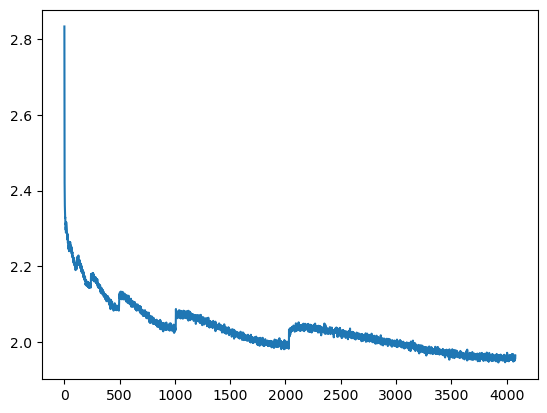

In [36]:
plt.plot(np.arange(len(Train)),Train)

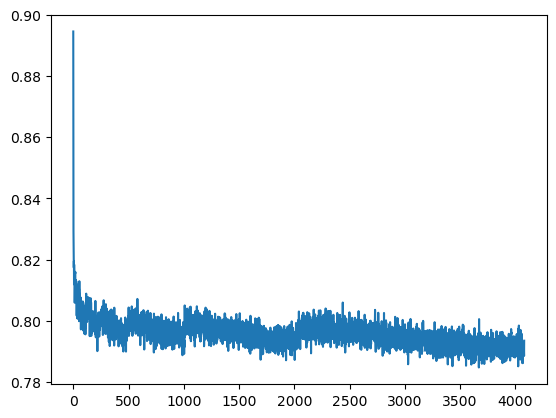

In [37]:
plt.plot(np.arange(len(Eval)),Eval)

In [38]:
fname = "models/stateATT_6L_12cont.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 
score_train = 0.7032224535942078

EVALUATING ON TEST DATA : 
score_test = 0.807023823261261

EVALUATING ON VAL DATA : 
score_val = 0.7923414707183838



EVALUATING ON TRAIN DATA : 


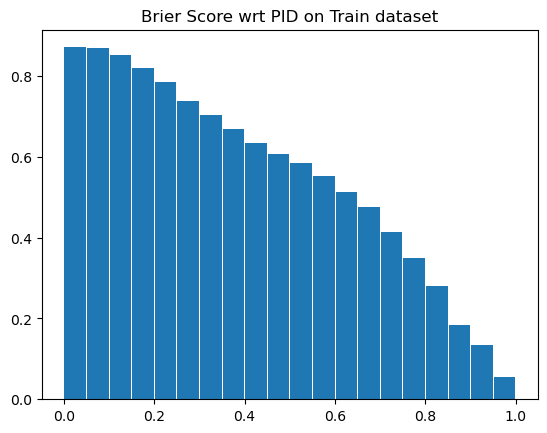

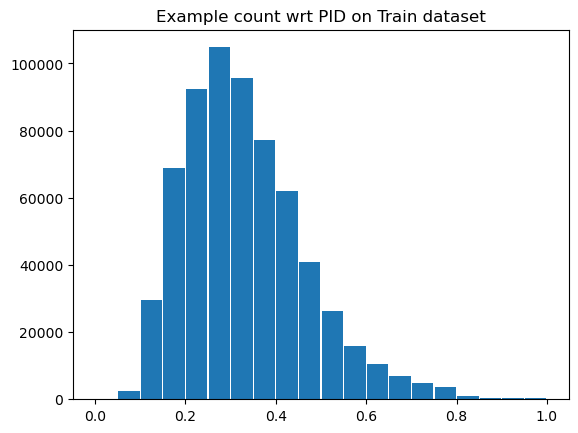

EVALUATING ON TEST DATA : 


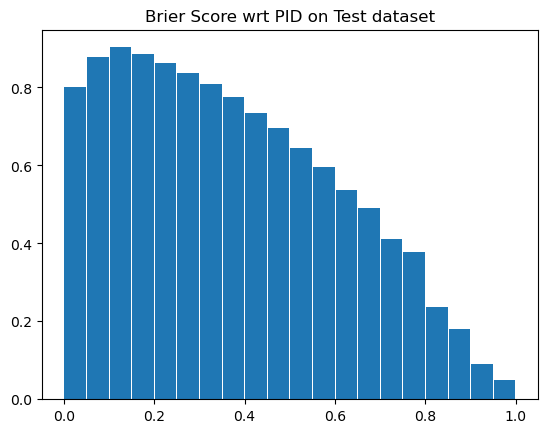

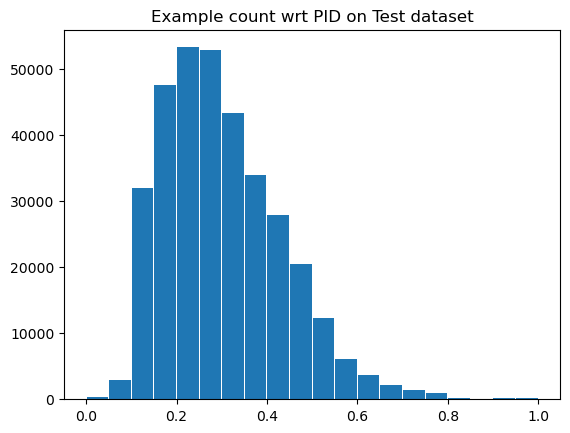

EVALUATING ON VAL DATA : 


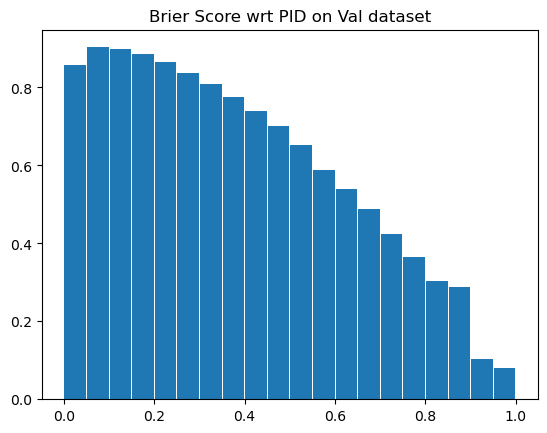

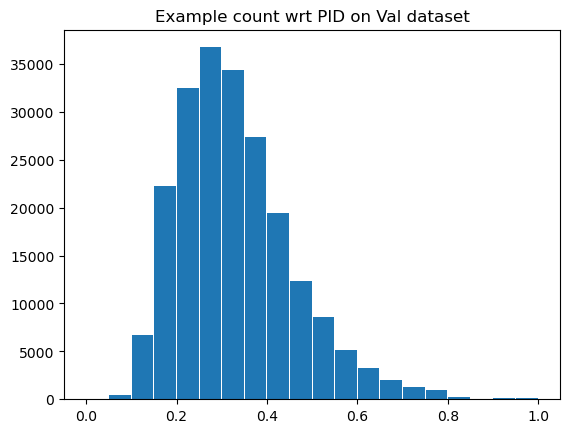

In [60]:
fname = "models/stateATT_6L_12cont.pth" 
SCORES = eval_model_PID(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 


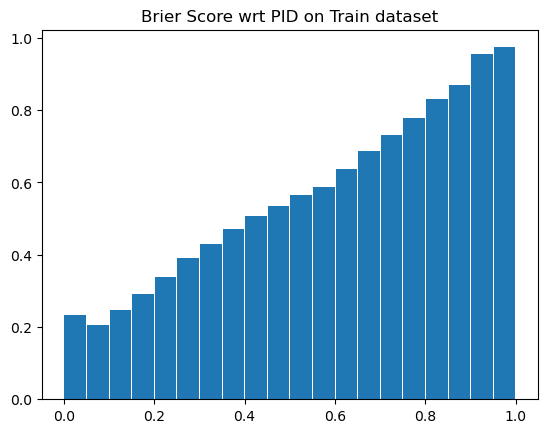

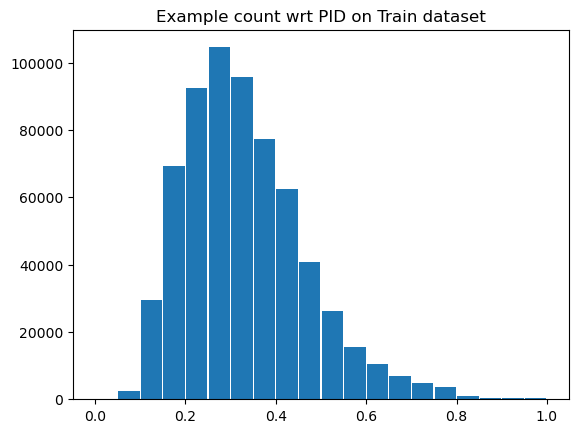

EVALUATING ON TEST DATA : 


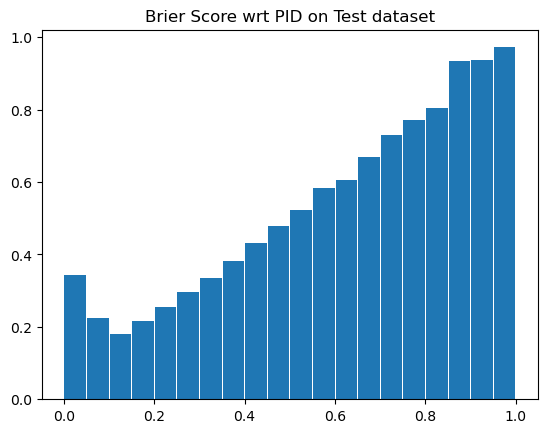

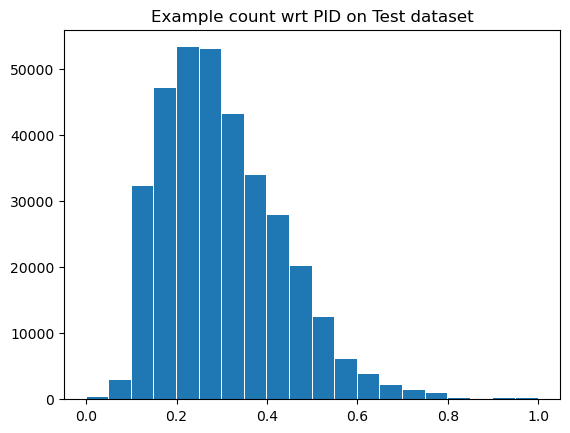

EVALUATING ON VAL DATA : 


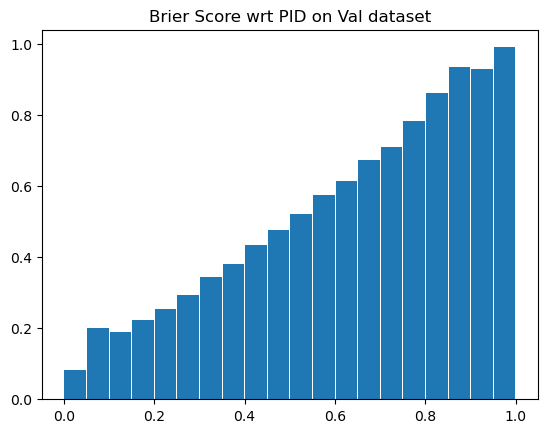

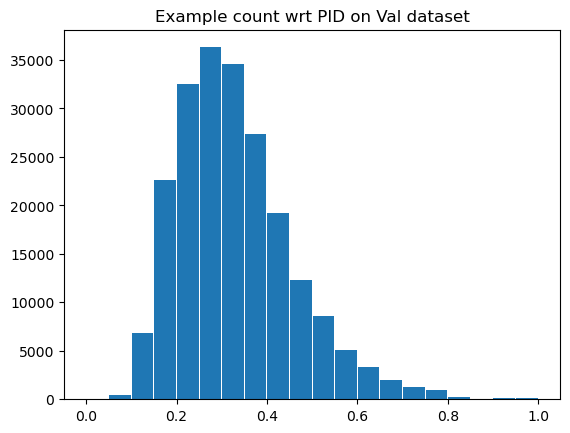

In [61]:
fname = "models/stateATT_6L_12cont.pth" 
SCORES = eval_model_acc_PID(fname,train_dataloader,test_dataloader,val_dataloader)

In [62]:
for i in range(3):
    print(SCORES[2*i])

tensor([0.2340, 0.2059, 0.2466, 0.2921, 0.3389, 0.3903, 0.4304, 0.4700, 0.5070,
        0.5352, 0.5661, 0.5882, 0.6363, 0.6860, 0.7304, 0.7787, 0.8309, 0.8683,
        0.9540, 0.9739])
tensor([0.3429, 0.2241, 0.1804, 0.2149, 0.2554, 0.2969, 0.3344, 0.3805, 0.4306,
        0.4790, 0.5231, 0.5830, 0.6068, 0.6696, 0.7304, 0.7698, 0.8045, 0.9355,
        0.9380, 0.9720])
tensor([0.0833, 0.1995, 0.1902, 0.2227, 0.2546, 0.2940, 0.3434, 0.3799, 0.4348,
        0.4755, 0.5208, 0.5761, 0.6146, 0.6742, 0.7102, 0.7846, 0.8635, 0.9342,
        0.9286, 0.9910])
